In [1]:
import os
from os.path import basename, dirname, join, exists
import sys
import glob 

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
from scipy.optimize import minimize
import geopandas as gpd 

from datetime import datetime
from datetime import timedelta
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines

# from pandas.tseries import converter

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 

import flopy.utils.binaryfile as bf


In [3]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
tprogs_id = '_no_conditioning'

data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [5]:
git_dir = join(doc_dir,'GitHub')
fxn_dir = git_dir+'/python_utilities'
if fxn_dir not in sys.path:
    sys.path.append(fxn_dir)
# sys.path
# import muskingum_recharge as mr

from importlib import reload
# reload(mr)

# Regional Model Connec3D input

In [6]:
# np.reshape fortran- F = first index is fastest, last is slowest, C = last is fastest, first is slowest
# CONNEC3D assumes Z is fastest then Y then X

In [7]:

tprogs_id = '_no_conditioning'
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files


In [8]:
# z, y, x
nlay, nrow, ncol = (320, 100,230)
arr_dim = (nlay,nrow,ncol)

In [9]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/levee_setback/setback_distance_analysis/'
model_ws = loadpth+'Connec3d' + tprogs_id
os.makedirs(model_ws, exist_ok=True)

In [139]:
def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities')
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

In [140]:

import tprogs_cleaning as tc
import tprogs_permeameter as tp

from importlib import reload
# importlib.reload
reload(tc)

<module 'tprogs_cleaning' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/tprogs_utilities\\tprogs_cleaning.py'>

In [17]:
# a basic connectivity run takes about 1 hour (7610 components), good enough in parallel with python
# might be worth trying to compile with ifortran to speed things up
# adding a compiler option seemed to speed things up
# reviewing CCO output showed a bad result (didn't line up with input) reshape order='F' is not needed

the runtime is incredibly long so I"m going to remove unnecessary cells from the calculation 
drop cells above land surface and cells outside of floodplain (3,000m limit) with a buffer for lateral connectivity
only 36 percent of coarse are within the floodplain  
-> decided not to do this so that in the future if someone wants it then it's available on the full scale.


In [13]:
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

str_setbacks = np.zeros((nrow,ncol))
buf_sfr = grid_sfr.copy()
# give lateral buffer of 600 to account for mean length
buf_sfr.geometry = grid_sfr.buffer(3800)
grid_sfr_buf = gpd.sjoin(grid_p,buf_sfr, how='right', lsuffix = 'grid', rsuffix = 'sfr',predicate='within')
grid_sfr_buf = grid_sfr_buf.drop_duplicates('node_grid')    
str_setbacks[grid_sfr_buf.row_grid.values-1,grid_sfr_buf.column_grid.values-1] = 1


In [14]:
tprogs_info = [80, -80, 320]

# masked_tprogs = tc.tprogs_cut_elev(tprogs_line, dem_data, tprogs_info)


In [15]:
chan_dir = box_dir+'channel_data/'

# str_setbacks = np.loadtxt(chan_dir+ 'regional_str_setback_id_arr.tsv', delimiter='\t').astype(int)
# # mask for easier setback referencing
# str_setbacks = np.where(str_setbacks==0,np.NaN, str_setbacks)

# dem data for cropping above land surface
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

In [16]:
import h5py
f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

## Iterate and write .dat files

In [97]:
# the dat files are slow to write and are better run with multiprocess
# write dat file input
for t in np.arange(0,1):
    tprogs_line = np.loadtxt(tprogs_files[t])
    # convert any negatives representing input data to same value
    tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))
    conn_arr = np.zeros((320, 100,230))
    # new array where sand, gravel (1,2) are 1-coarse and sandy mud, mud are 0-fine
    conn_arr[(tprogs_arr == 1)|(tprogs_arr == 2)] = 1
    # AJC new 2023-4-21, because CCO don't align with distinct units
    # change shape to be X, Y, Z for Connec3D
    conn_arr_t = np.transpose(conn_arr)
    # convert to z,y, x order
    conn_line = np.reshape(conn_arr_t, (320*100*230) ) #, order='F')

    dat_nam = 'r'+str(t).zfill(3)+'.DAT'
    np.savetxt(join(model_ws,  dat_nam), conn_line.astype(int))

In [98]:
# relatively small files so okay to run from notebook
# write par file input
for t in np.arange(0,1):
    dat_nam = 'r'+str(t).zfill(3)+'.DAT'
    connec_id = 1
    connec_pts = 6 # 6, 18, 26 point connectivity (faces, edge, corners)
    # dat file name
    # number of cells in x,y,z
    # x,y,z cell lengths
    # lags, Alisha recommended 30
    out_par = [str(connec_id),str(connec_pts), dat_nam, '230 100 320', '200 200 0.5', '30']
    out_par = '\n'.join(out_par) +'\n'

    with open(model_ws+ '/r'+str(t).zfill(3)+'.PAR', 'w') as f:
        f.write(out_par)
        # output file names
        f.write('r'+str(t).zfill(3)+'.STA\n')
        f.write('r'+str(t).zfill(3)+'.CCO\n')
        f.write('r'+str(t).zfill(3)+'.COF\n')



In [133]:
# Not used since multiprocess works
# write batch file input
# with open(model_ws+ '/00_run_all_series.bat', 'w') as f:
#     for t in np.arange(0,100):
#         file = 'r'+str(t).zfill(3)+'.PAR'
#         runline = 'echo '+ file +' | Connec3DLarge.exe\n'
#         f.write(runline) 


## Check output

In [17]:
t = 0
tprogs_line = np.loadtxt(tprogs_files[t])
# convert any negatives representing input data to same value
tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))
conn_arr = np.zeros((320, 100,230))
# new array where sand, gravel (1,2) are 1-coarse and sandy mud, mud are 0-fine
conn_arr[(tprogs_arr == 1)|(tprogs_arr == 2)] = 1

In [108]:
# Connec3D Connected Components Output file
cco_in = np.loadtxt(join(model_ws, 'r000.CCO'))
# reshape to array format
# cco = np.reshape(cco_in, arr_dim)
# account for transposing before input
cco = np.reshape(cco_in, np.flip(arr_dim))
cco = np.transpose(cco)


# Process output

In [129]:
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'

data_dir = box_dir+ tprogs_id+'/data_output/'
fig_dir = box_dir+tprogs_id+'/figures/'

In [158]:
def get_cco_vert(cco, dem_data):
    # identify the connected components, each has a unique number
    z,y,x = np.where(cco>0)
    val = cco[z,y,x]
    # np.transpose((z,y,x,val))
    # create a dataframe of the locations of connected components
    df = pd.DataFrame(np.transpose((z,y,x,val)),columns=['z','y','x','cc'])
    # find ground elevation at each connected point
    df['dem'] = dem_data[df.y.astype(int),df.x.astype(int)]
    # calculate elevation from tprogs layer
    df['elev'] = 80-z*0.5
    # check whether each layer is above land surface
    df['above_gse'] = (df.elev > df.dem) 
    # check wehether each layer is 30 m below land surface (100 ft)
#     df['below_30'] = (df.elev <= df.dem - 60)
    df['below_30'] = (df.elev <= - 79)
    df_sum = df.groupby('cc').sum()
    # find connected components that are above ground and connect deeper than 30m below
    df_conn = df_sum[(df_sum.above_gse>0).values & (df_sum.below_30 >0).values].index
    # check if top and bottom connected is in cco array
    cco_vert = np.isin(cco, df_conn)
    return(cco_vert)

In [159]:
cco_vert = get_cco_vert(cco, dem_data)
# tprogs_cleaning.get_tprogs_for_elev(dem_data)
tprogs_lay = tc.elev_to_tprogs_layers(elev=dem_data, tprogs_info=tprogs_info)
# elev_to_tprogs_layers?
rows = np.where(np.ones(tprogs_lay.shape)==1)[0]
cols = np.where(np.ones(tprogs_lay.shape)==1)[1]

In [160]:
# this 1% doesn't change between setting bottom 30 m below to the model bottom
# 1% of CCOs are not vertically connected
(cco_vert>0).sum()/(320*100*230), conn_arr.sum()/(320*100*230)

(0.24861127717391304, 0.25869198369565216)

In [161]:
# get high conductivity at ground surface
q_plt = np.zeros((100,230))
q_plt[rows,cols] = cco_vert[tprogs_lay[rows,cols],rows,cols] 
# plt.imshow(q_plt)

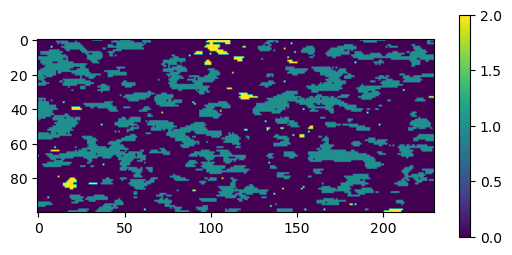

In [162]:
cco_plt = np.copy(cco_vert).astype(int)
cco_plt[cco_vert != conn_arr] = 2

# plt.imshow(q_plt)
plt.imshow(cco_plt[150])
plt.colorbar(shrink=0.6)
plt.show()


In [135]:
import time

In [133]:

def conn_count(cpts, str_setbacks):
    tic = time.time()
#     setbacks = np.unique(str_setbacks)
    setbacks = np.arange(0, str_setbacks.shape[0])
    setbacks = setbacks[~np.isnan(setbacks)]*200
    # will count total number of cells for each setback distance and for all 100 realizations
    hf_tot = np.zeros((100,len(setbacks)))
    # layer for each local setback
    num_sites = len(np.unique(local_str_setbacks))-1
    hf_tot_local = np.zeros((num_sites, 100,len(setbacks)))
    hf_all = np.zeros((100, 100, 230)) # map high flow for each realization
    
    # dataframe for grouping and area analysis
    stat_cols = ['Num_Grps','Mean','Median','Min','Max','Variance','Realization', 'Setback']
    cell_stats_all = pd.DataFrame(np.zeros((100*len(str_setbacks),len(stat_cols))), columns=stat_cols)
    local_cols = stat_cols+['Location']
    cell_stats_all_local = pd.DataFrame(np.zeros((num_sites*100*len(str_setbacks),len(local_cols))), columns=local_cols)
    
    k=0 # counter 
    kl = 0 # local counter
    for r in np.arange(0,100):
        print('Realization', r, ' time since start %.2f min' %((time.time()-tic)/60))
        cco_in = np.loadtxt(join(model_ws, 'r'+str(r).zfill(3)+'.CCO'))
        # reshape to array format
        cco = np.reshape(cco_in, arr_dim)
        cco_vert = get_cco_vert(cco, dem_data)
        # get high conductivity at ground surface
        q_lay = np.zeros((100,230))
        q_lay[rows,cols] = cco_vert[tprogs_lay[rows,cols],rows,cols] 
        
        hf_all[r,:] = np.copy(q_lay)
        # complete analysis for regional and local setbacks
        for n in np.arange(0,len(setbacks)):
            # overlay high flow cells with setback distance
#             q_lay_setback = tp.overlay_hf_setback(q_lay, str_setbacks < n+1)
            q_lay_setback = tp.overlay_hf_setback(q_lay, str_setbacks[n,:,:])
            # calculate total cells in each setback
            hf_tot[r,n] = q_lay_setback.sum()
            # calculate high flow groups and summary statistics
            cell_stats_all.iloc[k] = tp.calc_area_stats(r,n, 0, q_lay_setback, stat_cols)
            k +=1
            # iterate over local setbacks
            for l in np.unique(local_str_setbacks)[1:].astype(int):
                arr = np.zeros(local_str_setbacks[n,:,:].shape)
                arr[local_str_setbacks[n,::]==l] = 1
                q_lay_setback_local = tp.overlay_hf_setback(q_lay, arr)
#                 q_lay_setback_local = overlay_hf_setback(q_lay, arr)
                hf_tot_local[l-1,r,n] = q_lay_setback_local.sum()
                cell_stats_all_local.iloc[kl] = tp.calc_area_stats(r,n,l, q_lay_setback_local, local_cols)
                kl+=1
    hf_tot_df = pd.DataFrame(hf_tot, columns = setbacks)
    hf_tot_local = np.reshape(hf_tot_local, (num_sites*100,len(setbacks)))
    hf_tot_local_df = pd.DataFrame(hf_tot_local, columns = setbacks)
    hf_all_out = np.reshape(hf_all, (100*100, 230))
    np.savetxt(data_dir+'surface_highflow_by_realization_'+str(cpts)+'.tsv', hf_all_out, delimiter = '\t')
    
    # save counted high flow cells to a csv
    hf_tot_df.to_csv(data_dir+'surface_highflow_by_distance_regional_'+str(cpts)+'.csv', index=False)
    hf_tot_local_df.to_csv(data_dir+'surface_highflow_by_distance_local_'+str(cpts)+'.csv', index=False)
    # save grouping analysis and area statistics
    cell_stats_all.to_csv(data_dir+'surface_highflow_cells_statistics_regional'+str(cpts)+'.csv', index=False)
    cell_stats_all_local.to_csv(data_dir+'surface_highflow_cells_statistics_local'+str(cpts)+'.csv', index=False)

    toc = time.time()
    print('Total time was', (toc-tic)/60, 'minutes')

In [141]:
conn_count(6, str_setbacks)


Realization 0  time since start 0.00 min
Realization 1  time since start 0.07 min
Realization 2  time since start 0.13 min
Realization 3  time since start 0.19 min
Realization 4  time since start 0.25 min
Realization 5  time since start 0.31 min
Realization 6  time since start 0.37 min
Realization 7  time since start 0.43 min
Realization 8  time since start 0.49 min
Realization 9  time since start 0.55 min
Realization 10  time since start 0.61 min
Realization 11  time since start 0.68 min
Realization 12  time since start 0.74 min
Realization 13  time since start 0.80 min
Realization 14  time since start 0.86 min
Realization 15  time since start 0.92 min
Realization 16  time since start 0.99 min
Realization 17  time since start 1.06 min
Realization 18  time since start 1.12 min
Realization 19  time since start 1.19 min
Realization 20  time since start 1.25 min
Realization 21  time since start 1.32 min
Realization 22  time since start 1.38 min
Realization 23  time since start 1.44 min
Re